# Preprocessing

In [96]:
import chart_studio.plotly as py
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import plotly.express as px

data = pd.read_csv('final.csv')
data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
data.drop(['name','price'], axis=1, inplace=True)

le1=preprocessing.LabelEncoder()
data['big']=le1.fit_transform(data['big'])

le2=preprocessing.LabelEncoder()
data['medium']=le2.fit_transform(data['medium'])

le3=preprocessing.LabelEncoder()
data['small']=le3.fit_transform(data['small'])

#le1.inverse_transform(data['big'])

# Classification with Large Category Labels (w.o PCA)

In [80]:
X=data.iloc[:,:-3].to_numpy()
y=data.iloc[:, -3].to_numpy()
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

clf=OneVsRestClassifier(SVC()).fit(X_train, y_train)
clf.score(X_test, y_test)

0.6604058129969839

# Classification with Large Category Labels(PCA)

In [87]:
scaler=StandardScaler()
data_scaled=scaler.fit_transform(data.iloc[:, :-3].to_numpy())

pca=PCA()
pca.fit(data_scaled)
exp_var_cumul=np.cumsum(pca.explained_variance_ratio_)

# px.area(x=range(1, exp_var_cumul.shape[0]+1),
#        y=exp_var_cumul,
#        labels={'x': '#Components', 'y':'Explained Variance'})

pca=PCA(n_components=242)
pca_data=pca.fit_transform(data_scaled)

In [93]:
X=pca_data
y=data.iloc[:, -3].to_numpy()
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

clf=OneVsRestClassifier(SVC()).fit(X_train, y_train)
clf.score(X_test, y_test)

0.7666575267343022

# Classification with Medium Category Labels(w.o PCA)

In [102]:
X=data.iloc[:, :-3].to_numpy()
y=data.iloc[:, -2].to_numpy()
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

clf=OneVsRestClassifier(SVC()).fit(X_train, y_train)
clf.score(X_test, y_test)

0.6089936934466685

# Classification with Medium Category Labels(PCA)

In [103]:
X=pca_data
y=data.iloc[:, -2].to_numpy()
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

clf=OneVsRestClassifier(SVC()).fit(X_train, y_train)
clf.score(X_test, y_test)

0.6708253358925144

### Subset by Large Category
# Classification with Medium Category Labels(w.o PCA)

In [113]:
lst = []
score = []

for i in range(len(data['big'].value_counts().keys())):
    lst.append(data.groupby('big').get_group(i).to_numpy())

for i in range(41):
    pd.DataFrame(lst[i]).iloc[:, 512:].astype(int)
    X = pd.DataFrame(lst[i]).iloc[:, :-2].to_numpy()
    y = pd.DataFrame(lst[i]).iloc[:, -1].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=23)

    try:
        clf = OneVsRestClassifier(SVC()).fit(X_train, y_train)

        score.append(len(pd.DataFrame(lst[i]))*clf.score(X_test, y_test))
    except:
        continue

print(sum(score)/36468)

0.7690071292715285


### Subset by Large Category
# Classification with Medium Category Labels(PCA)

In [183]:
lst=[]
data_scaled=[]
pca_data=[]
score=[]

scaler=StandardScaler()

for i in range(len(data['big'].value_counts().keys())):
    lst.append(data.groupby('big').get_group(i).to_numpy())
    
    lst[i]=pd.DataFrame(lst[i])
    data_scaled.append(scaler.fit_transform(lst[i].iloc[:, :512].to_numpy()))
    
    pca=PCA()
    pca.fit(data_scaled[i])
    
    exp_var_cumul=np.cumsum(pca.explained_variance_ratio_)
    exp_var_cumul=pd.DataFrame(exp_var_cumul)
    
    pca=PCA(n_components=int(exp_var_cumul[exp_var_cumul>0.9].idxmin().values))
    pca_data.append(pca.fit_transform(data_scaled[i]))

In [184]:
for i in range(41):

    X=pd.concat([pd.DataFrame(pca_data[i]), pd.DataFrame(lst[i])[513].astype(int)], axis=1).iloc[:, :-1].to_numpy()
    y=pd.concat([pd.DataFrame(pca_data[i]), pd.DataFrame(lst[i])[513].astype(int)], axis=1).iloc[:, -1].to_numpy()

    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=0)
    
    clf=OneVsRestClassifier(SVC()).fit(X_train, y_train)
    score.append(len(pd.DataFrame(lst[i]))*clf.score(X_test, y_test))
    
print(sum(score)/36468)

0.838368689557889


# Visualize each method's score

In [353]:
models=['Large w.o PCA', 'Large with PCA', 'Medium w.o PCA', 'Medium with PCA', 'Subset w.o PCA', 'Subset with PCA']
scores=[0.6604058129969839, 0.7666575267343022, 0.6089936934466685 ,0.6708253358925144,0.7690071292715285,0.838368689557889]
viz=pd.DataFrame((scores, models)).T

fig=px.bar(viz, x=1, y=0)
fig.show()

# Content Based Filtering

In [327]:
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import matplotlib.font_manager as fm

font_path = r'Desktop/NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=18)

In [189]:
data=pd.read_csv('final.csv')
data=pd.DataFrame(data)
data.drop(['Unnamed: 0', 'Unnamed: 0.1', 'price'], axis=1, inplace=True)

In [195]:
refined_data=data.iloc[:, 1:513]

item_sim=cosine_similarity(refined_data, refined_data)

item_idx=[]
for i in range(36468):
    item_idx.append(pd.DataFrame(item_sim[i]).sort_values(by=[0], axis=0, ascending=False).iloc[1:11, :].index)

Which is the Item-code of item did consumer buy?
23


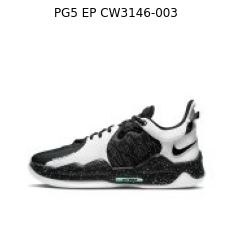

In [363]:
input_=int(input('Which is the Item-code of item did consumer buy?'+'\n'))
cust_lst=pd.DataFrame(item_idx).iloc[input_, :].values

bought_img=cv2.imread('images_data/test_'+str(input_)+'.png')
title=data['name'][input_]

plt.imshow(bought_img)
plt.title(title)
plt.axis('off')
plt.show()

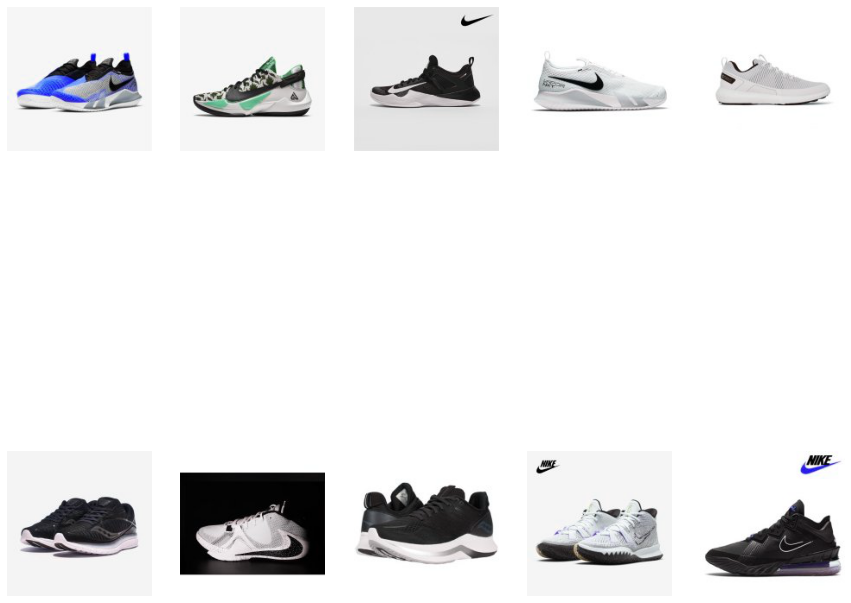

In [364]:
filename=[]
rows=2
cols=5
i=1
fig=plt.figure(figsize=(15, 15))
for j in cust_lst:
    filename.append('images_data/test_'+str(j)+'.png')
for name in filename:
    img=cv2.imread(name)
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(img)
    plt.axis('off')
    i+=1
plt.show()